# TESTING TREES...

>
![alt text](https://drive.google.com/uc?id=1Xvm8HeymRaVlqs_1qdy7eBlvsS_7FDoY)

#### Purpose of this notebook:

1. to test weekly versus daily
2. to test all 3000 products not just the 100 most popular

# Implementation Notes


*   weekly sql for one years of past data from that timeframe
*   weekly forecast? how to do every sunday and thursday?



#Shifted Target Features

* Another source of feature information is what I would call shifted target information or lagged features; that is we can look a recent, or relevant, observation of the thing we are trying to predict, and use this as a feature in the model.

* The important principle is that your model data must not contain information that would not be available at the time of prediction so a one day shift is only available one day before. So your model is only predicting one day ahead. If you wanted to forecast calls for the entire year upfront, you would not have access to the one day shifted information, and so you would need to make appropriate modifications to the shift i.e. 365 day shift.

* In the introduction we formulated the business problem as trying to predict seven days ahead so I have only included shifted targets that would be available 7 days before.

* We will also examine the impact on model performance of leaving these features out of the model, as leaving out the shifted variables will make the model’s use less restricted.

#LGBM EXAMPLES BELOW

EXCELLENT EXAMPLE: https://www.jpytr.com/post/time-series-with-gradient-boosted-models/

# Setups/ Imports

In [0]:
#Colab stuffs:

#get a fast operator system
!nvidia-smi

#mount google drive
from google.colab import drive
drive.mount('/content/drive')#click on the link it provides and copy and paste that code into the authorization area

#access the OS system to work with current directories:
import os

Sat Nov  2 19:42:42 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.50       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8    25W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
#Imports

import warnings 
warnings.filterwarnings('ignore')
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error

from math import sqrt
import statsmodels.api as sm
from sklearn import metrics
plt.style.use('fivethirtyeight')
sns.set_style("whitegrid")
sns.despine()
sns.set(rc={'figure.figsize':(15,9)})
%matplotlib inline

In [0]:
#import and clean DF
df2 = pd.read_csv('drive/My Drive/Capstone_2/data/100_items.csv', index_col= 'invdate', low_memory=False)#100 highest revenue items to test models
df = pd.read_csv('drive/My Drive/Capstone_2/data/one_year.csv', index_col= 'invdate', low_memory=False)#all 3000 product codes
df3 = pd.read_csv('drive/My Drive/Capstone_2/data/two_year.csv', index_col= 'invdate', low_memory=False)#all 3000 product codes

## Testing all product codes


*   First I need to filter out any item codes that are delivery based logs and not actual items
>* Will do this by catching any item string with less than 3 numbers which indicate its something like "SUGARTAX" or "BOTLEDEL"
*   Next I need to drop any items that haven't been ordered more than 10 times



In [0]:
#Counting Null values in df
print (df.isna().sum())

#getting rid of irrelevant columns
df.drop(columns= ['route', 'salesman'], inplace= True)

index               0
invno               0
item                0
desc                0
uom                 0
units               0
price               0
totalcost           0
ordqty              0
shipqty             0
diff_quantity       0
amount              0
profit              0
custno              0
sono_x              0
sono_y              0
paid                0
diff_amt_paid       0
duedate             0
days                0
status              0
datesold            0
delivery            0
route            3994
salesman         4001
priccode            0
orgprice            0
firstrun            0
added               0
invline             0
dtype: int64


In [0]:
#Getting rid of any non-item codes 
#filtering out the item codes with 2 or less numbers because these indicate non-plu codes
def count_numbers (df, col):
    
    #Turning items that have less than 3 numbers into nulls
    df[col] = df[col].apply(lambda x: x if sum(char.isdigit() for char in x) > 2 else np.nan)

    #Dropping the bad items from the data frame
    df.dropna(subset= [col],axis=0, inplace=True)

count_numbers(df, 'item')


In [0]:
#Dropping the negative values because they represent returns and we are only measuring demand/ returns is a different problem

#counting negative values
print (f'Number of Negative Order Quantities Values: {np.sum((df.ordqty < 0).values.ravel())}') 
print (f'Number of credits given to customer: {np.sum((df.price < 0).values.ravel())}') 

#dropping the return or negative value rows
df[df.ordqty < 0] = np.nan
df[df.price < 0] = np.nan
df.dropna(subset= ['ordqty'], axis= 0, inplace=True)

Number of Negative Order Quantities Values: 7624
Number of credits given to customer: 0


In [0]:
#Creating a normalized Order Qty column
df['norm_qty'] = df['ordqty'] / df['units']

In [0]:
#Creating a revenue column per item per day
df['revenue'] = df['shipqty'] * df['price']

In [0]:
#creating a column for the total orders per item
df['total_qty'] = df.groupby('item')["norm_qty"].transform('sum')

#creating a column for the total revenue per item
df['total_rev'] = df.groupby('item')["revenue"].transform('sum')

In [0]:
#splitting off the first phrase from the item's description, and turning them into lower case
df['label'] = df['desc'].str.split(",").str[0].str.lower()
df['label'] = df['label'].str.split(" ").str[0].str.lower()

In [0]:
#Figuring out all the low PLU quantities that were ordered ten times or less in a one year time frame

df['low_quantities'] = df['total_qty'].apply(lambda x: x if x > 10 else np.nan)
low= df[df['low_quantities'].isnull()]
print (f'Number of PLUs ordered less than 10 times last year = {low.item.nunique()}')
print ('List of all the PLUs ordered less than 10 times')
list(low.item.unique())

In [0]:
print (f'DF size before dropping the low quantity items = {df.shape[0]}')
print (f'Number of unique items(PLUs) before dropping the low quantity items = {df.item.nunique()}')
df.dropna(subset= ['low_quantities'], axis= 0, inplace=True)
print (f'DF size AFTER dropping the low quantity items = {df.shape[0]}')
print (f'Number of unique items(PLUs) AFTER dropping the low quantity items = {df.item.nunique()}')


DF size before dropping the low quantity items = 197420
Number of unique items(PLUs) before dropping the low quantity items = 2100
DF size AFTER dropping the low quantity items = 194544
Number of unique items(PLUs) AFTER dropping the low quantity items = 1332


*OK so we lost 768 items because they were too low of demand over a one years time period, but not suprisingly we did not loose too many entries in our invoice data since they represented so low of demand. We still have a lot of entries to work with.*

(array([74702., 38147., 22426., 18874., 12052.,  8043.,  4909.,  4010.,
         2777.,   275.,     0.,  4051.,  1639.,     0.,     0.,     0.,
            0.,  1310.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,  1329.]),
 array([1.01600000e+01, 4.57876800e+02, 9.05593600e+02, 1.35331040e+03,
        1.80102720e+03, 2.24874400e+03, 2.69646080e+03, 3.14417760e+03,
        3.59189440e+03, 4.03961120e+03, 4.48732800e+03, 4.93504480e+03,
        5.38276160e+03, 5.83047840e+03, 6.27819520e+03, 6.72591200e+03,
        7.17362880e+03, 7.62134560e+03, 8.06906240e+03, 8.51677920e+03,
        8.96449600e+03, 9.41221280e+03, 9.85992960e+03, 1.03076464e+04,
        1.07553632e+04, 1.12030800e+04, 1.16507968e+04, 1.20985136e+04,
        1.25462304e+04, 1.29939472e+04

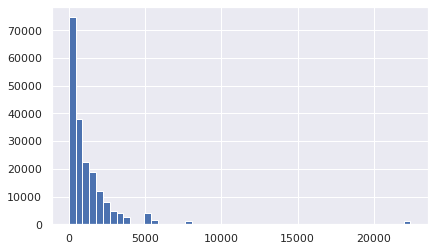

In [0]:
#quick visual of the demand of items after dropping the least ordered
plt.hist(df.total_qty, bins=50)

*So most of the demand is still centered around the zero mark which is good for a random forest which can handle the sparsity*

In [0]:
df.head(20)

In [0]:
#creating a data frame with just the normalized quantities ordered.
dfqty = pd.pivot_table(df, values= "norm_qty", index= "invdate", columns = "item", aggfunc=np.sum, fill_value=0)

# #Adding total columns--- dont think I want to add this...
# dfqty["day_total"]= dfqty.sum(axis = 1, skipna = True)

#resetting index to datetime
dfqty.index = pd.to_datetime(dfqty.index)

#filling in the missing days
idx = pd.date_range('2018-08-23', '2019-08-23')
dfqty = dfqty.reindex(idx, fill_value=0)

#Whoops accidentally did 366 days instead of 365! Let's fix that...
dfqty = dfqty[1:]

print (dfqty.shape)
dfqty.head()

(365, 1332)


item,10004PM,10004PS,10005,10005A,10006,10006E,10006F,10007A,10009PL,10011,10017,10018,10018D,10018E,10019A,10021,10026,10026B,10027,10027A,10027D,10028A,10028D,10032A,10033B,10036,10037,10040B,10041,10042,10042A,10042B,10042D,10043,10043A,10043B,10043C,10043D,10045D,10048A,...,G5101Q,G5102,G5102D,G5102E,G5102F,G5102G,G5102H,G5102I,G5102J,G5103,R10001,R10215,R10230,R10237,R10304,R10330,R10343,R10355,R10428,R10511,R20029,R20144,R20286,R20303,R30089,R30143,R30180,R30208,R30233,R30327,R30517,R30547,R30557,R30587,R30600,R30601,R30683,R40008,R50084,R60013
2018-08-24,0,0,0,0.0,0.0,0.0,0.0,4.0,0,0.0,0.0,0.0,0.0,9.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0,0.0,...,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-08-25,0,0,0,0.0,0.0,0.0,0.0,1.0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0,0.0,...,0,1,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.5,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-08-26,0,0,0,0.0,0.0,0.0,0.0,3.0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0.0,...,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-08-27,0,0,0,0.0,0.0,0.0,0.0,16.5,0,0.0,0.0,0.0,0.0,1.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,16.0,0.0,0.0,0.0,0.0,0.0,0,0.0,...,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-08-28,0,0,0,0.0,0.0,0.0,0.0,6.0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,1.0,4.5,0,0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0,0.0,...,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
dfwkly.index.unique()

DatetimeIndex(['2018-08-24', '2018-08-31', '2018-09-07', '2018-09-14',
               '2018-09-21', '2018-09-28', '2018-10-05', '2018-10-12',
               '2018-10-19', '2018-10-26', '2018-11-02', '2018-11-09',
               '2018-11-16', '2018-11-23', '2018-11-30', '2018-12-07',
               '2018-12-14', '2018-12-21', '2018-12-28', '2019-01-04',
               '2019-01-11', '2019-01-18', '2019-01-25', '2019-02-01',
               '2019-02-08', '2019-02-15', '2019-02-22', '2019-03-01',
               '2019-03-08', '2019-03-15', '2019-03-22', '2019-03-29',
               '2019-04-05', '2019-04-12', '2019-04-19', '2019-04-26',
               '2019-05-03', '2019-05-10', '2019-05-17', '2019-05-24',
               '2019-05-31', '2019-06-07', '2019-06-14', '2019-06-21',
               '2019-06-28', '2019-07-05', '2019-07-12', '2019-07-19',
               '2019-07-26', '2019-08-02', '2019-08-09', '2019-08-16'],
              dtype='datetime64[ns]', name='index', freq=None)

In [0]:
dfqty.shape

(365, 1332)

In [0]:
#Creating a weekly DF

dfwkly = dfqty.resample('7D').sum()
print (dfwkly.shape)

#resetting index to datetime
dfwkly.index = pd.to_datetime(dfwkly.index)

#Whoops accidentally did 53 weeks instead of 52! Let's fix that...
dfwkly = dfwkly[:-1]

print (dfwkly.shape)

(53, 1332)
(52, 1332)


In [0]:
#melting the training data

dfwkly.reset_index(inplace= True) #reset index for melt
melt = dfwkly.melt(id_vars='index', var_name='item', value_name='sales')
melt = melt.sort_values(['index', 'item'])
dfwkly.set_index('index', inplace= True) #put index back
print (f'Number of Rows in the melted dataframe: {melt.shape}')
num_rows= melt.shape[0]
print (melt.head())

Number of Rows in the melted dataframe: (69264, 3)
         index     item  sales
0   2018-08-24  10004PM    0.0
52  2018-08-24  10004PS    0.0
104 2018-08-24    10005    0.0
156 2018-08-24   10005A    0.0
208 2018-08-24    10006    0.0


*Bueno! We have 486180 rows to work with!*

# Feature Engineering

We need to create lots of feature for the trees to sort with. After we run a couple test cases, we can also trim these down once we figure out which ones do not beneift the model. We will add the following:

* Date features like day number, week number month number, ect.
>* Day number of the week (0-6, where 0 = Monday, 6 =Sunday)
* Lag and differences of the current weeks demand (usually very correlated, and generally the more the merrier)
>* I will be taking the lags and differences in 7 day increments. Why? Because I want to model weekly demand, not daily. 
* Holiday Features
>* As discussed with the client that pertains to their type of business


In [0]:
#Basic Feature engineering- Dates
melt2 = melt.copy()

melt2['date']= pd.to_datetime(melt2['index']) #converting index to a datetime
melt2.drop(columns= ['index'], inplace= True)


# Extracting date features
melt2['dayofmonth'] = melt2.date.dt.day
melt2['dayofyear'] = melt2.date.dt.dayofyear
melt2['dayofweek'] = melt2.date.dt.dayofweek
melt2['month'] = melt2.date.dt.month
melt2['year'] = melt2.date.dt.year
melt2['weekofyear'] = melt2.date.dt.weekofyear
melt2['is_month_start'] = (melt2.date.dt.is_month_start).astype(int)
melt2['is_month_end'] = (melt2.date.dt.is_month_end).astype(int)
melt2.head()

,item,sales,date,dayofmonth,dayofyear,dayofweek,month,year,weekofyear,is_month_start,is_month_end
0,10004PM,0.0,2018-08-24,24,236,4,8,2018,34,0,0
52,10004PS,0.0,2018-08-24,24,236,4,8,2018,34,0,0
104,10005,0.0,2018-08-24,24,236,4,8,2018,34,0,0
156,10005A,0.0,2018-08-24,24,236,4,8,2018,34,0,0
208,10006,0.0,2018-08-24,24,236,4,8,2018,34,0,0


In [0]:
melt2.columns

Index(['item', 'sales', 'date', 'dayofmonth', 'dayofyear', 'dayofweek',
       'month', 'year', 'weekofyear', 'is_month_start', 'is_month_end'],
      dtype='object')

In [0]:
melt2.head()

,item,sales,date,dayofmonth,dayofyear,dayofweek,month,year,weekofyear,is_month_start,is_month_end,last_wk_sales,last_wk_diff,log_sales,2wks_sales,2wks_diff,3wks_sales,3wks_diff,4wks_sales,4wks_diff,5wks_sales,5wks_diff,6wks_sales,6wks_diff,7wks_sales,7wks_diff,8wks_sales,8wks_diff
item,,,,,,,,,,,,,,,,,,,,,,,,,,,,


In [0]:
#Basic Feature Engineering- lags, differences, and logs-- These tend to help ALOT with time series data

melt2['last_wk_sales'] = melt2.groupby(['item'])['sales'].shift(1)
melt2['last_wk_diff'] = melt2.groupby(['item'])['sales'].diff(1)
melt2['log_sales'] = np.log1p(melt2.sales.values)# Converting sales to log(1+sales)
melt2['2wks_sales'] = melt2.groupby(['item'])['sales'].shift(2)
melt2['2wks_diff'] = melt2.groupby(['item'])['sales'].diff(2)
melt2['3wks_sales'] = melt2.groupby(['item'])['sales'].shift(3)
melt2['3wks_diff'] = melt2.groupby(['item'])['sales'].diff(3)
melt2['4wks_sales'] = melt2.groupby(['item'])['sales'].shift(4)
melt2['4wks_diff'] = melt2.groupby(['item'])['sales'].diff(4)
melt2['5wks_sales'] = melt2.groupby(['item'])['sales'].shift(5)
melt2['5wks_diff'] = melt2.groupby(['item'])['sales'].diff(5)
melt2['6wks_sales'] = melt2.groupby(['item'])['sales'].shift(6)
melt2['6wks_diff'] = melt2.groupby(['item'])['sales'].diff(6)
melt2['7wks_sales'] = melt2.groupby(['item'])['sales'].shift(7)
melt2['7wks_diff'] = melt2.groupby(['item'])['sales'].diff(7)
melt2['8wks_sales'] = melt2.groupby(['item'])['sales'].shift(7)
melt2['8wks_diff'] = melt2.groupby(['item'])['sales'].diff(7)
melt2 = melt2.dropna()

print (f'Number of Rows lost by differencing: {num_rows-melt2.shape[0]}') #how many rows did we loose from the differencing?
melt2.head()

Number of Rows lost by differencing: 9324


,item,sales,date,dayofmonth,dayofyear,dayofweek,month,year,weekofyear,is_month_start,is_month_end,last_wk_sales,last_wk_diff,log_sales,2wks_sales,2wks_diff,3wks_sales,3wks_diff,4wks_sales,4wks_diff,5wks_sales,5wks_diff,6wks_sales,6wks_diff,7wks_sales,7wks_diff,8wks_sales,8wks_diff
7,10004PM,0.0,2018-10-12,12,285,4,10,2018,41,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
59,10004PS,0.0,2018-10-12,12,285,4,10,2018,41,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
111,10005,0.0,2018-10-12,12,285,4,10,2018,41,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
163,10005A,0.0,2018-10-12,12,285,4,10,2018,41,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
215,10006,0.0,2018-10-12,12,285,4,10,2018,41,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
#converting date to index datetime
melt2.date = pd.to_datetime(melt2.date)
melt2.set_index('date', inplace= True)

In [0]:
#Adding Holidays--- these were events discussed with the customer

#adding holidays--- just create a column with a bunch of True and Falses for each holiday
melt2["new_years"] = melt2.index.dayofyear == 1
melt2["christmas"] = (melt2.index.month == 12) & ((melt2.index.day >= 18)&(melt2.index.day <= 26))
melt2["thanksgiving"] = (melt2.index.month == 11) & ((melt2.index.day >= 22)&(melt2.index.day <= 27))
melt2["farm2table"] = (melt2.index.month == 7) & ((melt2.index.day >= 1)&(melt2.index.day <= 15))
melt2["memorial_day"] = (melt2.index.month == 5) & ((melt2.index.day >= 18)&(melt2.index.day <= 28))
melt2["back_to_school"] = (melt2.index.month == 9) & (melt2.index.day == 1)


KeyError: ignored

In [0]:
melt2.head()

,item,sales,dayofmonth,dayofyear,dayofweek,month,year,weekofyear,is_month_start,is_month_end,last_wk_sales,last_wk_diff,log_sales,2wks_sales,2wks_diff,3wks_sales,3wks_diff,4wks_sales,4wks_diff,5wks_sales,5wks_diff,6wks_sales,6wks_diff,7wks_sales,7wks_diff,8wks_sales,8wks_diff,new_years,christmas,thanksgiving,farm2table,memorial_day,back_to_school
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-10-12,10004PM,0.0,12,285,4,10,2018,41,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,False,False,False
2018-10-12,10004PS,0.0,12,285,4,10,2018,41,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,False,False,False
2018-10-12,10005,0.0,12,285,4,10,2018,41,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,False,False,False
2018-10-12,10005A,0.0,12,285,4,10,2018,41,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,False,False,False
2018-10-12,10006,0.0,12,285,4,10,2018,41,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,False,False,False


Text(0.5, 1, 'Correlation Matrix od the different features')

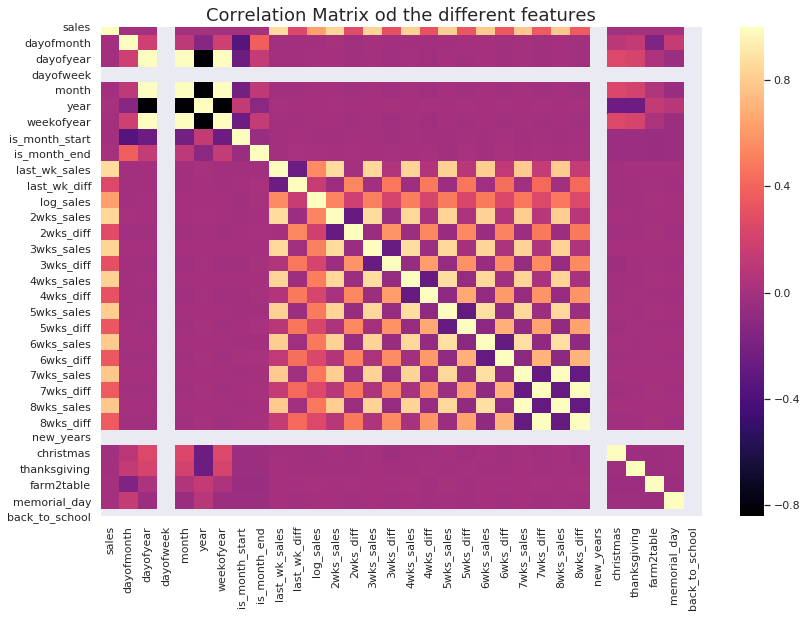

In [0]:
#I'm curious... how correlated are these variables to the actual sales?

# calculate the correlation matrix
corr = melt2.corr()

# plot the heatmap
plt.figure(figsize=(12,9))
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns, cmap='magma')

plt.title("Correlation Matrix od the different features", fontsize= 18)

#### INSIGHTS


*   Anything close to pink is not great correlation. Anything on the lighter or darker side is a good correlation with white being the best positive correlation and black being the best negative correlation.
* Looks like there is a fair amount of correlation between past sales. 
*   Not a lot of correlation with the other variables
* Day number of the week and week number of the year have a sliiiiiight correlation. This makes sense because our EDA was showing some weekly trends.



# Re-establishing a Baseline and Train/Validation Set

In [0]:
#rmse metric function
def rmse(ytrue, ypred):
  return (round(sqrt(mean_squared_error(ytrue, ypred)), 3))

#getting the last week of this subset of data
last_week = melt2['weekofyear'].iloc[-1] 

In [0]:
#Restablishing a Naive Baseline and a Validation Split

mean_error = []
for week in range(last_week-8, last_week): #setting up eight weeks train/validation set
    train = melt2[melt2['weekofyear'] < week] 
    val = melt2[melt2['weekofyear'] == week]
    
    p = val['last_wk_sales'].values
    
    error = rmse(val['sales'].values, p)
    print('Week %d - Error %.5f' % (week, error))
    mean_error.append(error)
naive_error= np.mean(mean_error)
print('Mean Error = %.5f' % naive_error)

Week 25 - Error 11.11500
Week 26 - Error 10.31400
Week 27 - Error 10.25300
Week 28 - Error 13.72300
Week 29 - Error 20.92800
Week 30 - Error 17.81100
Week 31 - Error 13.89800
Week 32 - Error 13.24700
Mean Error = 13.91113


Text(0.5, 1.0, 'Overall, how sparse is the demand of the items?')

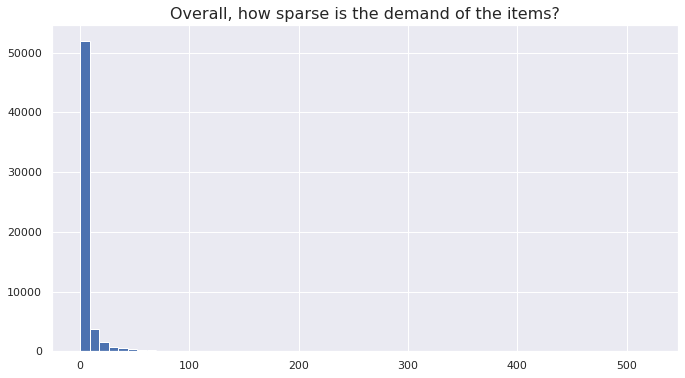

In [0]:
#You can SEE how sparse this data set is... how most of the demand is around 0
melt2['sales'].hist(bins=60, figsize=(10,6))
plt.title ("Overall, how sparse is the demand of the items?", fontsize= 16)

# Random Forest
* Before jumping straight into a Light Grandient Boost Model, lets first try a random forest.
* Random Forests are fantastic at being a great first model (out of the box) to throw at the problem.
* It has the ability to model multiple datatypes.
>* Later, I can play around with one-hot encoding on the categorical columns to see if that improves the score
* Parameters I will focus on= max number of trees, max depth of trees


In [0]:
#dropping columns that the Random forest cannot compute
melt2.reset_index(inplace= True)
melt2.drop(columns= 'date', inplace=True)
melt2.set_index('item', inplace=True)
melt2.head()

,sales,dayofmonth,dayofyear,dayofweek,month,year,weekofyear,is_month_start,is_month_end,last_wk_sales,last_wk_diff,log_sales,2wks_sales,2wks_diff,3wks_sales,3wks_diff,4wks_sales,4wks_diff,5wks_sales,5wks_diff,6wks_sales,6wks_diff,7wks_sales,7wks_diff,8wks_sales,8wks_diff,new_years,christmas,thanksgiving,farm2table,memorial_day,back_to_school
item,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
10004PM,0.0,12,285,4,10,2018,41,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,False,False,False
10004PS,0.0,12,285,4,10,2018,41,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,False,False,False
10005,0.0,12,285,4,10,2018,41,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,False,False,False
10005A,0.0,12,285,4,10,2018,41,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,False,False,False
10006,0.0,12,285,4,10,2018,41,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,False,False,False


In [0]:
mean_error = []

for week in range(last_week-8, last_week): #setting up 8 weeks train/test set
  
    train = melt2[melt2['weekofyear'] < week]
    val = melt2[melt2['weekofyear'] == week]
    
    xtr, xts = train.drop(['sales'], axis=1), val.drop(['sales'], axis=1)
    ytr, yts = train['sales'].values, val['sales'].values
    
    mdl = RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=0)
    mdl.fit(xtr, ytr)
    
    p = mdl.predict(xts)
    
    error = rmse(yts, p)
    print('Week %d - Error %.5f' % (week, error))
    mean_error.append(error)
    
print('Mean Error = %.5f' % np.mean(mean_error))

Week 26 - Error 0.64600
Week 27 - Error 0.38400
Week 28 - Error 0.19400
Week 29 - Error 0.30700
Week 30 - Error 0.10500
Week 31 - Error 0.17300
Week 32 - Error 0.07700
Week 33 - Error 0.42700
Mean Error = 0.28913


#### Is my model overfitting?


* If the training error is low and the validation error is much higher, your model is overfitting.
*   YES, empirically trees can definitely over fit.
*   One way to prevent overfitting is to trim the trees and indicate a max number of leaves. I will create a grid search, and then visualize the testing versus the training data and see at which values overfitting is occuring.


In [0]:
#Is my model over fitting here? Possibly! Let's take a look at how max_depth affects overfitting
#We'll take the last week in the data set as the testing set and train on the other weeks

train = melt2[melt2['weekofyear'] < 33] #NOTE: our training set gets smaller the further out the weeks are
test = melt2[melt2['weekofyear'] == 33]
    
x_train, x_test = train.drop(['sales'], axis=1), test.drop(['sales'], axis=1)
y_train, y_test = train['sales'].values, test['sales'].values


max_depths = np.linspace(1, 15, 15, endpoint=True)
train_results = []
test_results = []

for max_depth in max_depths:
  rf = RandomForestRegressor(n_estimators=1000, max_depth=max_depth, n_jobs=-1)
  rf.fit(x_train, y_train)
  train_p = rf.predict(x_train)
  train_err = rmse(y_train, train_p)
  train_results.append(train_err)
  
  test_p = rf.predict(x_test)
  test_err = rmse(y_test, test_p)
  test_results.append(test_err)

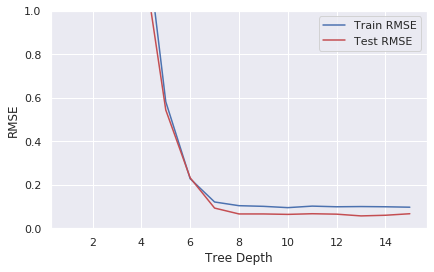

In [0]:
#Plot Tree Depth of Testing Versus Training
plt.plot(max_depths, train_results, color= 'b', label='Train RMSE')
plt.plot(max_depths, test_results, color= 'r', label='Test RMSE')
plt.legend()
plt.ylabel('RMSE')
plt.ylim(0,1)
plt.xlabel('Tree Depth')
plt.show()

#### INSIGHTS
*GREAT! Tree depth of 5 seems to be a good trade-off between a lower RMSE and being able to genralize into the future. Although, all these values seem to be doing fairly well and not over fitting too badly.*

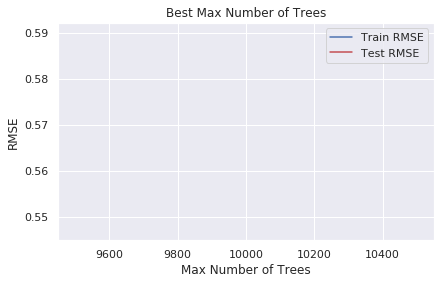

CPU times: user 19min 34s, sys: 3.28 s, total: 19min 37s
Wall time: 9min 59s


In [0]:
#Let's do the same thing for the max number of trees, and see what the optimal balance of lower RMSE without overfitting
%%time

train = melt2[melt2['weekofyear'] < 33] #NOTE: our training set gets smaller the further out the weeks are
test = melt2[melt2['weekofyear'] == 33]
    
x_train, x_test = train.drop(['sales'], axis=1), test.drop(['sales'], axis=1)
y_train, y_test = train['sales'].values, test['sales'].values


num_trees = [10000] #100, 500, 750, 1000, 2000
train_results = []
test_results = []
 
for num in num_trees:
  rf = RandomForestRegressor(n_estimators=num, max_depth= 5, n_jobs=-1)
  rf.fit(x_train, y_train)
  train_p = rf.predict(x_train)
  train_err = rmse(y_train, train_p)
  train_results.append(train_err)
  
  test_p = rf.predict(x_test)
  test_err = rmse(y_test, test_p)
  test_results.append(test_err)

#Plot Tree Depth of Testing Versus Training
plt.plot(num_trees, train_results, color= 'b', label='Train RMSE')
plt.plot(num_trees, test_results, color= 'r', label='Test RMSE')
plt.legend()
plt.title("Best Max Number of Trees")
plt.ylabel('RMSE')
plt.xlabel('Max Number of Trees')
plt.show()



In [0]:
print (train_results, test_results)

[0.59] [0.547]


#### INSIGHTS


*   Hookay, between 10, 50, 100, 500, 1000 which number is the best?
*   1000 seems the be the optimal max number of trees which also helps with computing power



## Testing daily order qty for all the viable PLU codes...


In [0]:
melt2 [melt2.weekofyear == 33]

,sales,dayofmonth,dayofyear,dayofweek,month,year,weekofyear,is_month_start,is_month_end,last_wk_sales,last_wk_diff,log_sales,2wks_sales,2wks_diff,3wks_sales,3wks_diff,4wks_sales,4wks_diff,5wks_sales,5wks_diff,6wks_sales,6wks_diff,7wks_sales,7wks_diff,8wks_sales,8wks_diff,new_years,christmas,thanksgiving,farm2table,memorial_day,back_to_school
item,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
10004PM,0.0,16,228,4,8,2019,33,0,0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,False,False,False
10004PS,0.0,16,228,4,8,2019,33,0,0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,False,False,False
10005,0.0,16,228,4,8,2019,33,0,0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,False,False,False
10005A,0.0,16,228,4,8,2019,33,0,0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,False,False,False
10006,0.0,16,228,4,8,2019,33,0,0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
R30601,1.0,16,228,4,8,2019,33,0,0,1.0,0.0,0.693147,0.0,1.0,1.1,-0.1,0.0,1.0,0.5,0.5,2.0,-1.0,0.0,1.0,0.0,1.0,False,False,False,False,False,False
R30683,1.1,16,228,4,8,2019,33,0,0,0.0,1.1,0.741937,0.0,1.1,0.0,1.1,0.0,1.1,1.0,0.1,0.0,1.1,0.0,1.1,0.0,1.1,False,False,False,False,False,False
R40008,0.0,16,228,4,8,2019,33,0,0,3.1,-3.1,0.000000,17.0,-17.0,16.2,-16.2,1.1,-1.1,5.1,-5.1,5.0,-5.0,0.0,0.0,0.0,0.0,False,False,False,False,False,False


In [0]:
#Officially training and testing the last weeks model with the best tree parameters
  
#def model(df, week):

%%time 
train = melt2[melt2['weekofyear'] < 33]
test = melt2[melt2['weekofyear'] == 33]
    
x_train, x_test = train.drop(['sales'], axis=1), test.drop(['sales'], axis=1)
y_train, y_test = train['sales'].values, test['sales'].values
    
mdl = RandomForestRegressor(n_estimators=1000, max_depth= 5, n_jobs=-1, random_state=0)
mdl.fit(x_train, np.log1p(y_train))
    
p_train = np.expm1(mdl.predict(x_train))
train_error = rmse(y_train, p_train) 
print (f'Train Error= {train_error}')

pred_vs_actual_train = pd.DataFrame({
    'actual': y_train,
    'predicted': p_train,
    'error_rf': (((p_train-y_train)/y_train*100)),
    'rmse': train_error,
})
pred_vs_actual_train= pred_vs_actual_train.round(3)
        
p = np.expm1(mdl.predict(x_test))
error = rmse(y_test, p)
print (f'Test Error= {error}')

pred_vs_actual_test = pd.DataFrame({
    'actual': y_test,
    'predicted': p,
    'error_rf': (((p-y_test)/y_test*100)),
    'rmse': error,
})
pred_vs_actual_test= pred_vs_actual_test.round(3)

Train Error= 2.948
Test Error= 1.202
CPU times: user 1min 58s, sys: 396 ms, total: 1min 58s
Wall time: 1min


In [0]:
#Test
test.reset_index(inplace=True)
results_test = pd.concat([test, pred_vs_actual_test], axis=1, sort=False)
results_test= results_test[['item', 'weekofyear', 'actual', 'last_wk_sales','predicted', 'error_rf', 'rmse']]
results_test['error_n']= ((results_test.last_wk_sales.values- results_test.actual.values)/results_test.actual.values)*100

print (results_test)


         item  weekofyear  actual  ...  error_rf   rmse  error_n
0     10004PM          33     0.0  ...       inf  1.202      NaN
1     10004PS          33     0.0  ...       inf  1.202      NaN
2       10005          33     0.0  ...       inf  1.202      NaN
3      10005A          33     0.0  ...       inf  1.202      NaN
4       10006          33     0.0  ...       inf  1.202      NaN
...       ...         ...     ...  ...       ...    ...      ...
1327   R30601          33     1.0  ...     0.115  1.202      0.0
1328   R30683          33     1.1  ...    -8.987  1.202   -100.0
1329   R40008          33     0.0  ...       inf  1.202      inf
1330   R50084          33     1.0  ...     0.115  1.202     60.0
1331   R60013          33     4.0  ...    -1.843  1.202    -75.0

[1332 rows x 8 columns]


How much better did the Random Forest perform than the Naive Model?
Random Forest model increased performance by:  91.36 % 



Text(0.5, 1.0, 'How well did the Random Forest Do?')

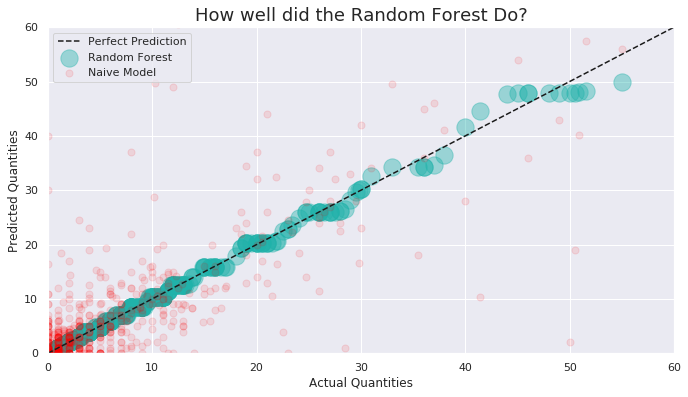

In [0]:
#Actual values versus predicted values
print ("How much better did the Random Forest perform than the Naive Model?")
print(f'Random Forest model increased performance by: {abs((error-naive_error)/naive_error) * 100: .2f} % \n')
plt.figure(figsize=(10,6))
plt.scatter(results_test.actual, results_test.predicted, s=300, color='lightseagreen', alpha= .4, label= "Random Forest")
plt.scatter(results_test.actual, results_test.last_wk_sales, s=50, color='red', alpha= .1, label= "Naive Model")

x = np.linspace(0,60,60)
y = x
plt.plot(x, y, 'k', linestyle='--', label= "Perfect Prediction")
plt.legend()
plt.ylim(0,60)
plt.xlim(0,60)
plt.xlabel('Actual Quantities')
plt.ylabel('Predicted Quantities')
plt.title("How well did the Random Forest Do?", fontsize= 18)


#### Insights


*   Runs fairly slow, I can adjust number of trees to improve this and see how that affects the performance
*   62% increase in performance!



In [0]:
feature_importances = pd.Series(mdl.feature_importances_, index=x_train.columns)
feature_importances.sort_values(inplace=True, ascending=False)
feature_importances[:50].plot.bar( color="dodgerblue", figsize= (10,8), width= 1)
plt.title("Most Important Features for Random Forest")

# Light Gradiant Boost Model
* Cutting edge with gradient boosting!
* Wins lots of Kaggle Competitions!
* Seems to be super efficient

In [0]:
#LGBM WITH logged data

mean_error = []

for week in range(last_week-8, last_week): #setting up 8 weeks train/test set
  
    train = melt2[melt2['weekofyear'] < week]
    val = melt2[melt2['weekofyear'] == week]
    
    xtr, xts = train.drop(['sales'], axis=1), val.drop(['sales'], axis=1)
    ytr, yts = train['sales'].values, val['sales'].values
    
    mdl = LGBMRegressor(n_estimators=1000, learning_rate=0.01)
    mdl.fit(xtr, np.log1p(ytr))
    
    p = np.expm1(mdl.predict(xts))
    
    error = rmse(yts, p)
    print('Week %d - Error %.5f' % (week, error))
    mean_error.append(error)
    


Week 26 - Error 0.40700
Week 27 - Error 0.67300
Week 28 - Error 0.86800
Week 29 - Error 0.50800
Week 30 - Error 0.40700
Week 31 - Error 0.29000
Week 32 - Error 0.56600
Week 33 - Error 0.03500


In [0]:
print ("How Well Did the Models Do?\n")

print (f"Mean Error of Naive Model = {naive_error}")
print ("Mean Error of Random Forest= 0.289")
print(f"Mean Error of a LGBM = {np.mean(mean_error):.3f}" )

How Well Did the Models Do?

Mean Error of Naive Model = 7.71675
Mean Error of Random Forest= 0.289
Mean Error of a LGBM = 0.469


In [0]:
#parameter hyper tuning

# params = {
#     'boosting_type': 'gbdt',  # np.random.choice(['dart', 'gbdt']),
#     'objective': 'binary',
#     'metric': ['binary_logloss', 'auc'], 
    
#     'learning_rate': 0.35,
    
#     'num_leaves': np.random.randint(64, 128),
#     'max_depth': np.random.randint(6, 12),
#     'min_data_in_leaf': int(2 ** (np.random.rand()*3.5 + 9)),
    
#     'feature_fraction': np.random.rand()*0.35+0.65,
#     'bagging_fraction': np.random.rand()*0.35+0.65,
#     'bagging_freq': 1,
    
#     'lambda_l1': 10 ** (np.random.rand() * 4),
#     'lambda_l2': 10 ** (np.random.rand() * 3 + 2),
#     'min_gain_to_split': 0.0,
#     'min_sum_hessian_in_leaf': 0.1,
    
#     'num_threads': 16,
#     'verbose': 0,
#     'is_training_metric': 'True'
# }

In [0]:
# Hypertune Parameters of LGBM Model

from sklearn.model_selection import GridSearchCV
estimator = LGBMRegressor()

param_grid = {
    'learning_rate': [0.01, 0.05, .1, .2, .3],
    'n_estimators': [20, 50, 100, 500, 1000],
    'num_leaves':[3,4,5,6,7,8,9,10,15,20,25,30]
}

gbm = GridSearchCV(estimator, param_grid, cv=3)
gbm.fit(x_train, y_train)

print('Best parameters found by grid search are:', gbm.best_params_)

Best parameters found by grid search are: {'learning_rate': 0.05, 'n_estimators': 1000, 'num_leaves': 4}


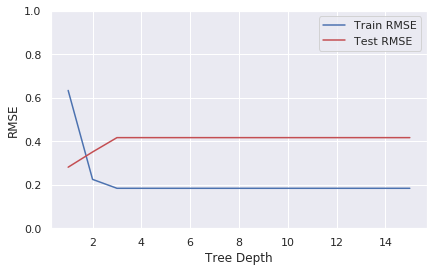

CPU times: user 1min 4s, sys: 445 ms, total: 1min 5s
Wall time: 34.2 s


In [0]:
#Is my model over fitting here? Possibly! Let's take a look at how max_depth affects overfitting
#We'll take the last week in the data set as the testing set and train on the other weeks

%%time 
train = melt2[melt2['weekofyear'] < 33] #NOTE: our training set gets smaller the further out the weeks are
test = melt2[melt2['weekofyear'] == 33]
    
x_train, x_test = train.drop(['sales'], axis=1), test.drop(['sales'], axis=1)
y_train, y_test = train['sales'].values, test['sales'].values


max_depths = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
train_results = []
test_results = []

for max_depth in max_depths:
  lgb = LGBMRegressor(n_estimators=1000, num_leaves=4, max_depth=max_depth, learning_rate=0.05)
  lgb.fit(x_train, y_train)
  train_p = lgb.predict(x_train)
  train_err = rmse(y_train, train_p)
  train_results.append(train_err)
  
  test_p = lgb.predict(x_test)
  test_err = rmse(y_test, test_p)
  test_results.append(test_err)

#Plot Tree Depth of Testing Versus Training
plt.plot(max_depths, train_results, color= 'b', label='Train RMSE')
plt.plot(max_depths, test_results, color= 'r', label='Test RMSE')
plt.legend()
plt.ylabel('RMSE')
plt.ylim(0,1)
plt.xlabel('Tree Depth')
plt.show()

#### INSIGHTS


*   Best parameters found by grid search are: {'learning_rate': 0.05, 'n_estimators': 1000, 'num_leaves': 4}
*   To prevent overfitting max_depth is set to 2 to prevent overfitting



In [0]:
#Officially training and testing the last weeks model with the best tree parameters
  
#def model(df, week):

%%time 
train = melt2[melt2['weekofyear'] < 34]
test = melt2[melt2['weekofyear'] == 34]
    
x_train, x_test = train.drop(['sales'], axis=1), test.drop(['sales'], axis=1)
y_train, y_test = train['sales'].values, test['sales'].values
    
lgb = LGBMRegressor(n_estimators=1000, num_leaves=4, max_depth= 2, learning_rate=0.05)
lgb.fit(x_train, np.log1p(y_train))
    
p_train = np.expm1(lgb.predict(x_train))
train_error = rmse(y_train, p_train) 
print (f'Train Error= {train_error}')

pred_vs_actual_train = pd.DataFrame({
    'actual': y_train,
    'predicted': p_train,
    'error_rf': (((p_train-y_train)/y_train*100)),
    'rmse': train_error,
})
pred_vs_actual_train= pred_vs_actual_train.round(3)
        
p = np.expm1(lgb.predict(x_test))
error = rmse(y_test, p)
print (f'Test Error= {error}')

pred_vs_actual_test = pd.DataFrame({
    'actual': y_test,
    'predicted': p,
    'error_rf': (((p-y_test)/y_test*100)),
    'rmse': error,
})
pred_vs_actual_test= pred_vs_actual_test.round(3)

Train Error= 0.218
Test Error= 0.521
CPU times: user 4.31 s, sys: 33.9 ms, total: 4.34 s
Wall time: 2.26 s


How much better did the LightGBM perform than the Naive Model?
LightGBM increased performance by:  93.25 % 



Text(0.5, 1.0, 'How well did the LightGradientBoost Model Do?')

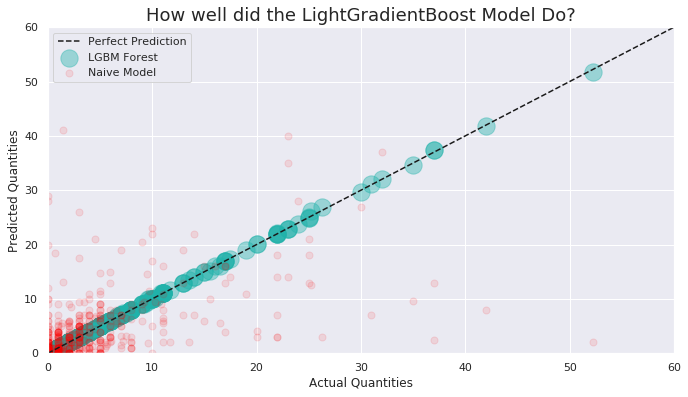

In [0]:
#Test
test.reset_index(inplace=True)
results_test = pd.concat([test, pred_vs_actual_test], axis=1, sort=False)
results_test= results_test[['item', 'weekofyear', 'actual', 'last_wk_sales','predicted', 'error_rf', 'rmse']]
results_test['error_n']= ((results_test.last_wk_sales.values- results_test.actual.values)/results_test.actual.values)*100

#Actual values versus predicted values
print ("How much better did the LightGBM perform than the Naive Model?")
print(f'LightGBM increased performance by: {abs((error-naive_error)/naive_error) * 100: .2f} % \n')
plt.figure(figsize=(10,6))
plt.scatter(results_test.actual, results_test.predicted, s=300, color='lightseagreen', alpha= .4, label= "LGBM Forest")
plt.scatter(results_test.actual, results_test.last_wk_sales, s=50, color='red', alpha= .1, label= "Naive Model")

x = np.linspace(0,60,60)
y = x
plt.plot(x, y, 'k', linestyle='--', label= "Perfect Prediction")
plt.legend()
plt.ylim(0,60)
plt.xlim(0,60)
plt.xlabel('Actual Quantities')
plt.ylabel('Predicted Quantities')
plt.title("How well did the LightGradientBoost Model Do?", fontsize= 18)


#### Which features are the most important?

Text(0.5, 1.0, 'Most Important Features for LightGB MODEL')

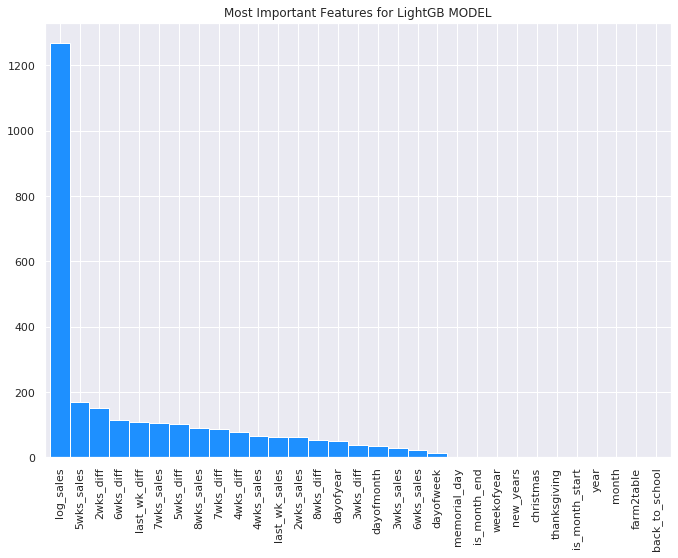

In [0]:
# feature importances
feature_importances = pd.Series(lgb.feature_importances_, index=x_train.columns)
feature_importances.sort_values(inplace=True, ascending=False)
feature_importances[:50].plot.bar( color="dodgerblue", figsize= (10,8), width= 1)
plt.title("Most Important Features for LightGB MODEL")

# Questions

1. Is LGBM overfitting?
2.   Can I drop features that don't make a difference?
3.   Which models should I use?
4.  HOW TO TRANSLATE WHAT I HAVE TO ACTUAL WEEKLY PREDICTIONS????????????
    >* so i would have to create a data of x_variables somehow and then that would be my prediction for the y variables!
    >* how to create a data frame of x_variables?
5. HOW TO IMPLEMENT THIS MODEL IN THE REAL WORLD???
6.Can I implement every Sunday and Thursday?
7.best way to calculate accuracy for model?? percent change from naive RMSE to new RMSE????



# NOTES HOW TO REDUCE OVERFITTING

Tuning for overfitting

In addition to the parameters mentioned above the following parameters can be used to control overfitting:

* max_bin: the maximum numbers bins that feature values are bucketed in. A smaller max_bin reduces overfitting.
* min_child_weight: the minimum sum hessian for a leaf. In conjuction with min_child_samples, larger values reduce overfitting.
* bagging_fraction and bagging_freq: enables bagging (subsampling) of the training data. Both values need to be set for bagging to be used. The frequency controls how often (iteration) bagging is used. Smaller fractions and frequencies reduce overfitting.
* feature_fraction: controls the subsampling of features used for training (as opposed to subsampling the actual training data in the case of bagging). Smaller fractions reduce overfitting.
* lambda_l1 and lambda_l2: controls L1 and L2 regularization.